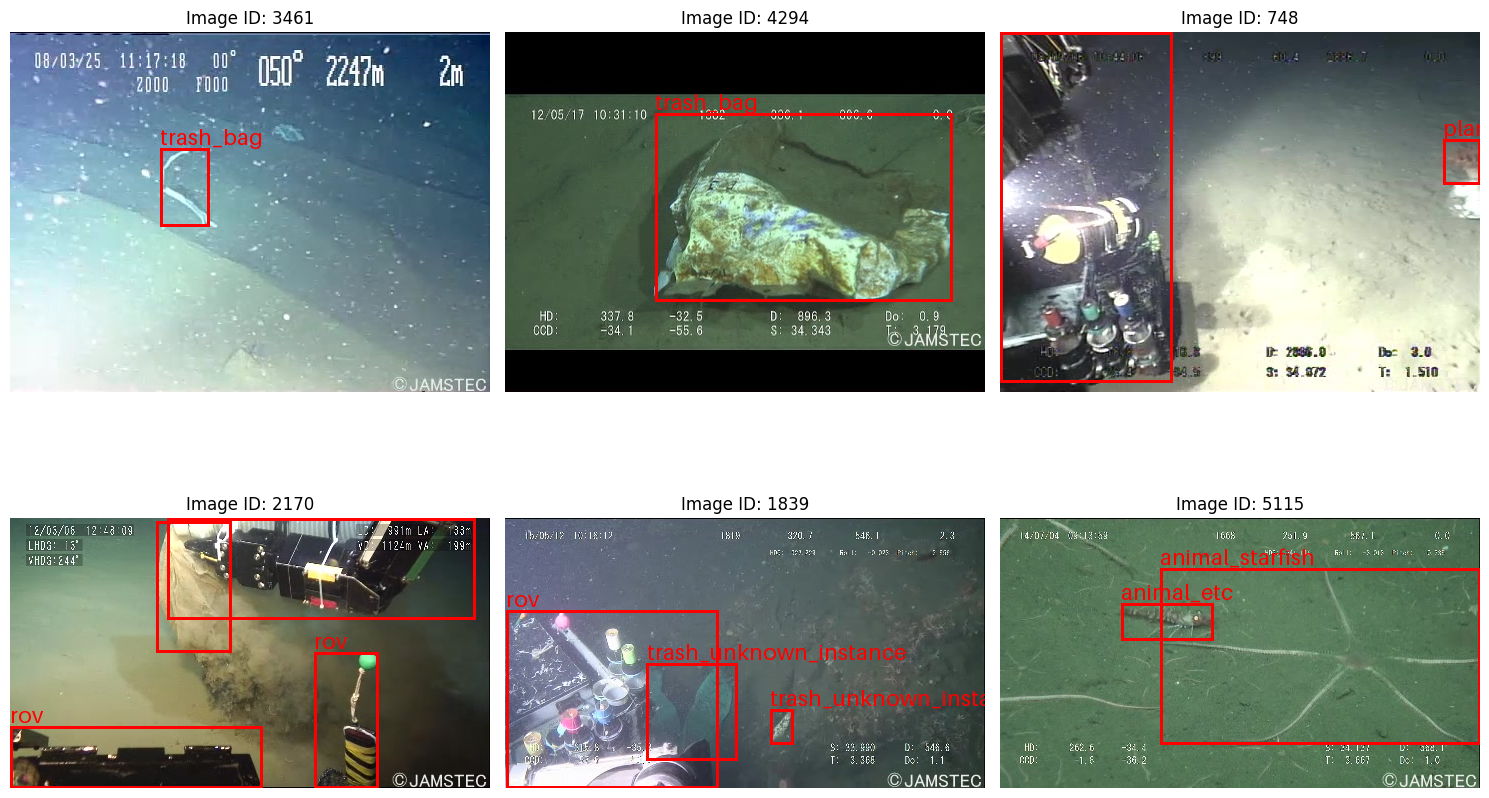

In [2]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

# Paths to your dataset
image_folder = "../dataset/instance_version/train/"
annotations_file = "../dataset/instance_version/instances_train_trashcan.json"

# Load the annotations
with open(annotations_file, "r") as f:
    data = json.load(f)

# Load the images and annotations
images = data["images"]
annotations = data["annotations"]

id_to_name = {category["id"]: category["name"] for category in data["categories"]}

# Create a mapping from image_id to its annotations
image_to_annotations = {}
for annotation in annotations:
    image_id = annotation["image_id"]
    if image_id not in image_to_annotations:
        image_to_annotations[image_id] = []
    image_to_annotations[image_id].append(annotation)

# Select six images to display
selected_images = random.sample(images, 6)

# Plot the images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Set up the font for drawing text
font = ImageFont.load_default(
    size=22
)  # Fallback to default font if TrueType font is not available

for idx, img_info in enumerate(selected_images):
    image_id = img_info["id"]
    image_path = os.path.join(image_folder, img_info["file_name"])

    # Open the image
    img = Image.open(image_path)

    # Draw the bounding boxes
    draw = ImageDraw.Draw(img)
    if image_id in image_to_annotations:
        for annotation in image_to_annotations[image_id]:
            bbox = annotation["bbox"]  # [x, y, width, height]
            x, y, w, h = bbox
            draw.rectangle([x, y, x + w, y + h], outline="red", width=3)

            # Add the class name with a larger font
            category_id = annotation["category_id"]
            category = id_to_name[category_id]
            draw.text(
                (x, y - 25), category, fill="red", font=font
            )  # Adjust vertical offset for visibility

    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title(f"Image ID: {image_id}")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(selected_images) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [3]:
import os
import json
from PIL import Image
from tqdm import tqdm

# Paths to your dataset
image_folder = "../dataset/instance_version/train/"
annotations_file = "../dataset/instance_version/instances_train_trashcan.json"
output_folder = "../cropped_dataset/"
padding_factor = 0.45  # Percentage of the bounding box size to pad
padding_max = 100  # Maximum padding in pixels

# Load the annotations
with open(annotations_file, "r") as f:
    data = json.load(f)

# Extract categories and create id-to-name mapping
categories = data["categories"]
id_to_name = {category["id"]: category["name"] for category in categories}

# Ensure output directories exist
os.makedirs(output_folder, exist_ok=True)
for category_name in id_to_name.values():
    os.makedirs(os.path.join(output_folder, category_name), exist_ok=True)

# Create a new annotations mapping
new_annotations = {category_name: [] for category_name in id_to_name.values()}

# Process each image
for img_info in tqdm(data["images"], desc="Processing images"):
    image_id = img_info["id"]
    image_path = os.path.join(image_folder, img_info["file_name"])
    img = Image.open(image_path)

    # Get annotations for this image
    annotations = [
        ann for ann in data["annotations"] if ann["image_id"] == image_id
    ]

    for ann in annotations:
        category_id = ann["category_id"]
        category_name = id_to_name[category_id]
        bbox = ann["bbox"]  # [x, y, width, height]

        # Compute padding based on percentage
        x, y, w, h = bbox
        padding_x = min(int(w * padding_factor), padding_max)
        padding_y = min(int(h * padding_factor), padding_max)

        # Compute the crop region
        left = max(0, int(x) - padding_x)
        top = max(0, int(y) - padding_y)
        right = min(img.width, int(x + w) + padding_x)
        bottom = min(img.height, int(y + h) + padding_y)

        # Crop the image
        cropped_img = img.crop((left, top, right, bottom))

        # Save the cropped image
        cropped_img_name = f"{image_id}_{ann['id']}.jpg"
        cropped_img_path = os.path.join(output_folder, category_name, cropped_img_name)
        cropped_img.save(cropped_img_path)

        # Update the bounding box coordinates relative to the cropped image
        new_bbox = [
            x - left,
            y - top,
            w,
            h,
        ]

        # Add the new annotation
        new_annotations[category_name].append({
            "file_name": cropped_img_name,
            "bbox": new_bbox,
            "category_id": category_id,
            "category_name": category_name,
        })

# Save new JSON files for each category
for category_name, annotations in new_annotations.items():
    output_json_path = os.path.join(output_folder, category_name, f"bboxes.json")
    with open(output_json_path, "w") as f:
        json.dump({"annotations": annotations}, f, indent=4)

print(f"New dataset created at {output_folder}")

Processing images: 100%|██████████| 6065/6065 [00:28<00:00, 211.89it/s]


New dataset created at ../cropped_dataset/


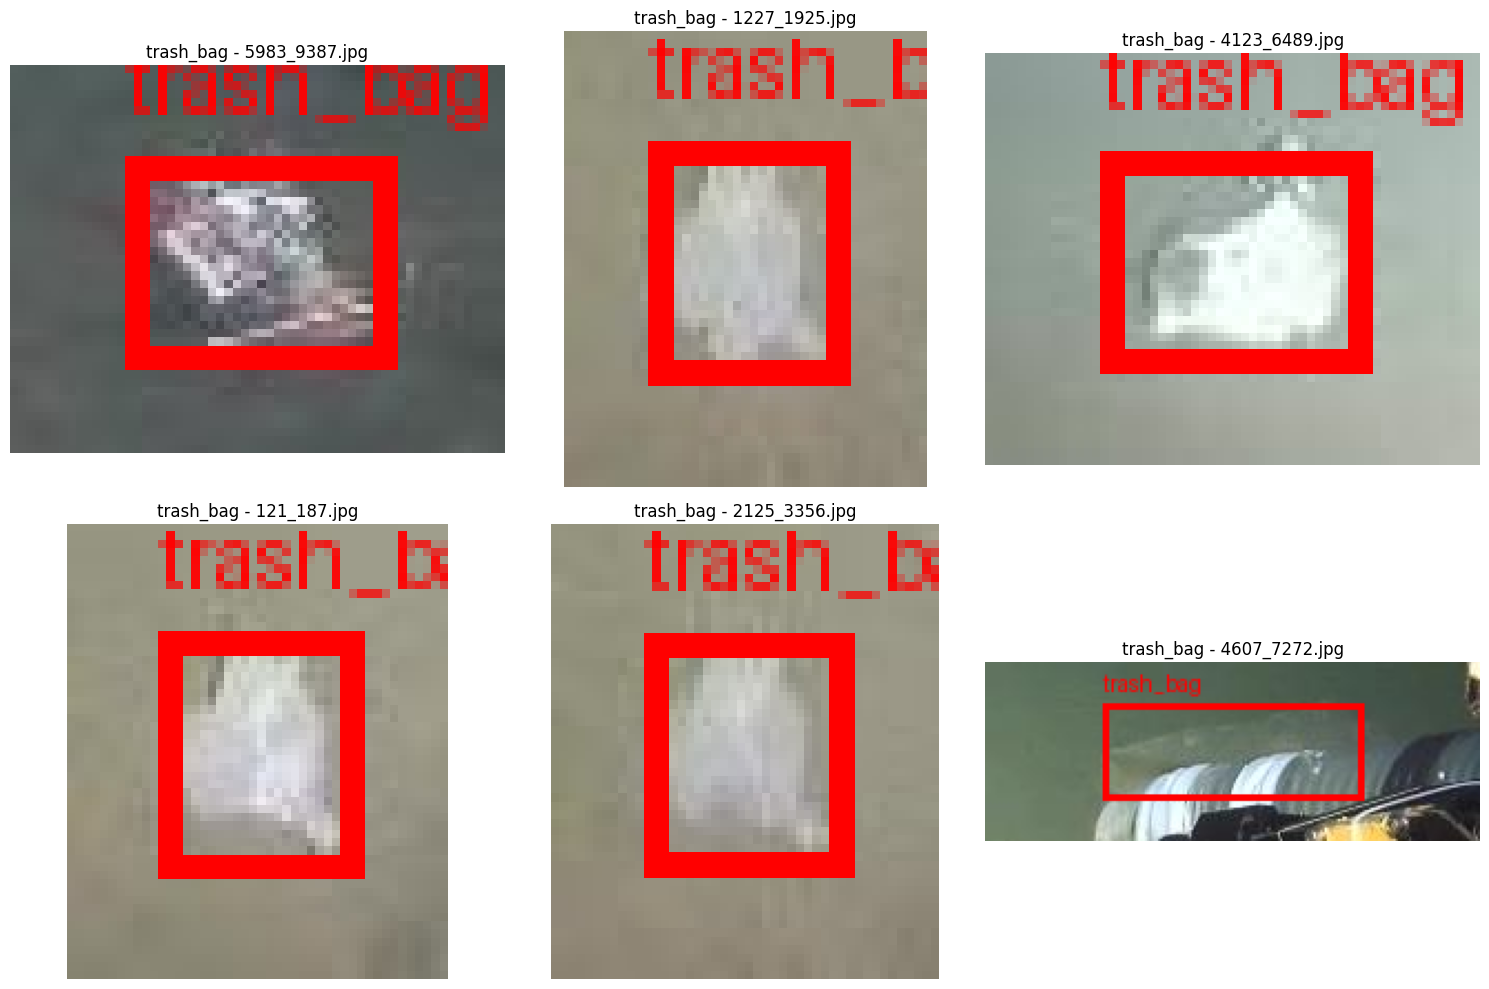

In [4]:
import os
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

# Path to the new dataset
cropped_dataset_folder = "../cropped_dataset/"

# Font setup for text
try:
    font = ImageFont.truetype("arial.ttf", size=16)
except IOError:
    font = ImageFont.load_default()

# Iterate over class folders
categories = [d for d in os.listdir(cropped_dataset_folder) if os.path.isdir(os.path.join(cropped_dataset_folder, d))]

# Randomly select a category
selected_category = "trash_bag"
category_folder = os.path.join(cropped_dataset_folder, selected_category)

# Load the JSON file for the selected category
json_path = os.path.join(category_folder, f"bboxes.json")
with open(json_path, "r") as f:
    annotations = json.load(f)["annotations"]

# Randomly select six images to display
selected_annotations = random.sample(annotations, min(6, len(annotations)))

# Plot the images with bounding boxes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, annotation in enumerate(selected_annotations):
    img_path = os.path.join(category_folder, annotation["file_name"])
    img = Image.open(img_path)

    # Draw bounding box
    draw = ImageDraw.Draw(img)
    bbox = annotation["bbox"]
    x, y, w, h = bbox
    draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
    draw.text((x, y - 15), annotation["category_name"], fill="red", font=font)

    # Display the image
    axes[idx].imshow(img)
    axes[idx].set_title(f"{annotation['category_name']} - {annotation['file_name']}")
    axes[idx].axis("off")

# Hide unused subplots
for ax in axes[len(selected_annotations):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Print all categories
i=0
for category_id, category_name in id_to_name.items():
    i+=1
    print(f"{i}, \"{category_name}\",")
    

1, "rov",
2, "plant",
3, "animal_fish",
4, "animal_starfish",
5, "animal_shells",
6, "animal_crab",
7, "animal_eel",
8, "animal_etc",
9, "trash_clothing",
10, "trash_pipe",
11, "trash_bottle",
12, "trash_bag",
13, "trash_snack_wrapper",
14, "trash_can",
15, "trash_cup",
16, "trash_container",
17, "trash_unknown_instance",
18, "trash_branch",
19, "trash_wreckage",
20, "trash_tarp",
21, "trash_rope",
22, "trash_net",


In [13]:
import os
import json
import random
from PIL import Image
from tqdm import tqdm

# Paths
output_folder = "../dataset_finetuning/train/"
cropped_dataset_folder = "../cropped_dataset/"
categories = [
    "rov",
    "plant",
    "animal_fish",
    "animal_starfish",
    "animal_shells",
    "animal_crab",
    "animal_eel",
    "animal_etc",
    "trash_clothing",
    "trash_pipe",
    "trash_bottle",
    "trash_bag",
    "trash_snack_wrapper",
    "trash_can",
    "trash_cup",
    "trash_container",
    "trash_unknown_instance",
    "trash_branch",
    "trash_wreckage",
    "trash_tarp",
    "trash_rope",
    "trash_net"
    ]

labels = {
    "rov": "A rov underwater",
    "plant": "A plant underwater",
    "animal_fish": "A fish underwater",
    "animal_starfish": "A starfish underwater",
    "animal_shells": "A shells underwater",
    "animal_crab": "A crab underwater",
    "animal_eel": "An eel underwater",
    "animal_etc": "An animal underwater",
    "trash_clothing": "A clothing trash underwater",
    "trash_pipe": "A pipe trash underwater",
    "trash_bottle": "A bottle trash underwater",
    "trash_bag": "A bag trash underwater",
    "trash_snack_wrapper": "A snack wrapper trash underwater",
    "trash_can": "A can trash underwater",
    "trash_cup": "A cup trash underwater",
    "trash_container": "A container trash underwater",
    "trash_unknown_instance": "An unknown trash underwater",
    "trash_branch": "A branch trash underwater",
    "trash_wreckage": "A wreckage trash underwater",
    "trash_tarp": "A tarp trash underwater",
    "trash_rope": "A rope trash underwater",
    "trash_net": "A net trash underwater"
}


N = 50
min_size = 150

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over categories
for category in categories:
    category_folder = os.path.join(output_folder, category)
    os.makedirs(category_folder, exist_ok=True)
    source_category_folder = os.path.join(cropped_dataset_folder, category)
    json_file = os.path.join(source_category_folder, "bboxes.json")
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON file not found for category: {category}")
    with open(json_file, "r") as f:
        data = json.load(f)
    valid_images = []
    for annotation in data["annotations"]:
        img_path = os.path.join(source_category_folder, annotation["file_name"])
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                width, height = img.size
                if width > min_size and height > min_size:
                    valid_images.append({
                        "file_name": annotation["file_name"],
                        "bbox": annotation["bbox"],
                        "category_id": annotation["category_id"],
                        "category_name": annotation["category_name"],
                    })
    if len(valid_images) < N:
        """ raise ValueError(
            f"Not enough valid images in category '{category}'. Found {len(valid_images)}, required {N}."
        ) """
        print(f"Not enough valid images in category '{category}'. Found {len(valid_images)}, required {N}.")
        
    sampled_images = random.sample(valid_images, min(N, len(valid_images)))
    for img_info in tqdm(sampled_images, desc=f"Copying sampled images for {category}"):
        src_path = os.path.join(source_category_folder, img_info["file_name"])
        dest_path = os.path.join(category_folder, img_info["file_name"])
        with Image.open(src_path) as img:
            img.save(dest_path)

output_csv_file = os.path.join(output_folder, "metadata.csv")
with open(output_csv_file, "w") as f:
    f.write("file_name,text\n")
    for category in categories:
        category_folder = os.path.join(output_folder, category)
        for file in os.listdir(category_folder):
            f.write(f"{category}/{file},{labels[category]}\n")

Copying sampled images for animal_fish: 100%|██████████| 50/50 [00:00<00:00, 417.52it/s]


Not enough valid images in category 'animal_starfish'. Found 16, required 50.


Copying sampled images for animal_starfish: 100%|██████████| 16/16 [00:00<00:00, 374.90it/s]


Not enough valid images in category 'animal_shells'. Found 0, required 50.


Copying sampled images for animal_shells: 0it [00:00, ?it/s]
Copying sampled images for animal_crab: 100%|██████████| 50/50 [00:00<00:00, 401.54it/s]


Not enough valid images in category 'animal_eel'. Found 24, required 50.


Copying sampled images for animal_etc: 100%|██████████| 50/50 [00:00<00:00, 419.35it/s]


Not enough valid images in category 'trash_clothing'. Found 32, required 50.


Copying sampled images for trash_pipe: 100%|██████████| 50/50 [00:00<00:00, 377.31it/s]


Not enough valid images in category 'trash_bottle'. Found 36, required 50.


Copying sampled images for trash_bag: 100%|██████████| 50/50 [00:00<00:00, 453.15it/s]


Not enough valid images in category 'trash_snack_wrapper'. Found 24, required 50.


Copying sampled images for trash_snack_wrapper: 100%|██████████| 24/24 [00:00<00:00, 439.93it/s]


Not enough valid images in category 'trash_can'. Found 15, required 50.


Copying sampled images for trash_can: 100%|██████████| 15/15 [00:00<00:00, 393.54it/s]


Not enough valid images in category 'trash_cup'. Found 12, required 50.


Copying sampled images for trash_container: 100%|██████████| 50/50 [00:00<00:00, 535.40it/s]
Copying sampled images for trash_unknown_instance: 100%|██████████| 50/50 [00:00<00:00, 479.01it/s]
Copying sampled images for trash_wreckage: 100%|██████████| 50/50 [00:00<00:00, 299.96it/s]


Not enough valid images in category 'trash_tarp'. Found 45, required 50.


Copying sampled images for trash_tarp: 100%|██████████| 45/45 [00:00<00:00, 320.28it/s]


Not enough valid images in category 'trash_rope'. Found 39, required 50.


Copying sampled images for trash_rope: 100%|██████████| 39/39 [00:00<00:00, 349.76it/s]


Not enough valid images in category 'trash_net'. Found 40, required 50.


Copying sampled images for trash_net: 100%|██████████| 40/40 [00:00<00:00, 394.08it/s]


In [14]:
import os
import json
import random
from PIL import Image
from tqdm import tqdm

# Paths
output_folder = "../dataset_finetuning2/train/"
cropped_dataset_folder = "../cropped_dataset/"

categories = [
    "rov",
    "plant",
    "animal_fish",
    "animal_starfish",
    "animal_shells",
    "animal_crab",
    "animal_eel",
    "animal_etc",
    "trash_clothing",
    "trash_pipe",
    "trash_bottle",
    "trash_bag",
    "trash_snack_wrapper",
    "trash_can",
    "trash_cup",
    "trash_container",
    "trash_unknown_instance",
    "trash_branch",
    "trash_wreckage",
    "trash_tarp",
    "trash_rope",
    "trash_net"
    ]

labels = {
    "rov": "A rov underwater",
    "plant": "A plant underwater",
    "animal_fish": "A fish underwater",
    "animal_starfish": "A starfish underwater",
    "animal_shells": "A shells underwater",
    "animal_crab": "A crab underwater",
    "animal_eel": "An eel underwater",
    "animal_etc": "An animal underwater",
    "trash_clothing": "A clothing trash underwater",
    "trash_pipe": "A pipe trash underwater",
    "trash_bottle": "A bottle trash underwater",
    "trash_bag": "A bag trash underwater",
    "trash_snack_wrapper": "A snack wrapper trash underwater",
    "trash_can": "A can trash underwater",
    "trash_cup": "A cup trash underwater",
    "trash_container": "A container trash underwater",
    "trash_unknown_instance": "An unknown trash underwater",
    "trash_branch": "A branch trash underwater",
    "trash_wreckage": "A wreckage trash underwater",
    "trash_tarp": "A tarp trash underwater",
    "trash_rope": "A rope trash underwater",
    "trash_net": "A net trash underwater"
}

#N = 50
N = 25
min_size = 256
#min_size = 150

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over categories
for category in categories:
    category_folder = os.path.join(output_folder, category)
    os.makedirs(category_folder, exist_ok=True)
    source_category_folder = os.path.join(cropped_dataset_folder, category)
    json_file = os.path.join(source_category_folder, "bboxes.json")
    if not os.path.exists(json_file):
        raise FileNotFoundError(f"JSON file not found for category: {category}")
    with open(json_file, "r") as f:
        data = json.load(f)
    valid_images = []
    for annotation in data["annotations"]:
        img_path = os.path.join(source_category_folder, annotation["file_name"])
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                width, height = img.size
                if width > min_size and height > min_size:
                    valid_images.append({
                        "file_name": annotation["file_name"],
                        "bbox": annotation["bbox"],
                        "category_id": annotation["category_id"],
                        "category_name": annotation["category_name"],
                    })
    if len(valid_images) < N:
        """ raise ValueError(
            f"Not enough valid images in category '{category}'. Found {len(valid_images)}, required {N}."
        ) """
        print(f"Not enough valid images in category '{category}'. Found {len(valid_images)}, required {N}.")
    sampled_images = random.sample(valid_images, min(N, len(valid_images)))
    for img_info in tqdm(sampled_images, desc=f"Copying sampled images for {category}"):
        src_path = os.path.join(source_category_folder, img_info["file_name"])
        dest_path = os.path.join(category_folder, img_info["file_name"])
        with Image.open(src_path) as img:
            img.save(dest_path)

output_csv_file = os.path.join(output_folder, "metadata.csv")
with open(output_csv_file, "w") as f:
    f.write("file_name,text\n")
    for category in categories:
        category_folder = os.path.join(output_folder, category)
        for file in os.listdir(category_folder):
            f.write(f"{category}/{file},{labels[category]}\n")

Copying sampled images for animal_fish: 100%|██████████| 25/25 [00:00<00:00, 481.00it/s]


Not enough valid images in category 'animal_starfish'. Found 3, required 25.


Copying sampled images for animal_starfish: 100%|██████████| 3/3 [00:00<00:00, 426.15it/s]


Not enough valid images in category 'animal_shells'. Found 0, required 25.


Copying sampled images for animal_shells: 0it [00:00, ?it/s]
Copying sampled images for animal_crab: 100%|██████████| 25/25 [00:00<00:00, 450.18it/s]


Not enough valid images in category 'animal_eel'. Found 8, required 25.


Copying sampled images for animal_etc: 100%|██████████| 25/25 [00:00<00:00, 460.36it/s]


Not enough valid images in category 'trash_clothing'. Found 21, required 25.


Copying sampled images for trash_clothing: 100%|██████████| 21/21 [00:00<00:00, 429.52it/s]


Not enough valid images in category 'trash_pipe'. Found 24, required 25.


Copying sampled images for trash_pipe: 100%|██████████| 24/24 [00:00<00:00, 432.42it/s]


Not enough valid images in category 'trash_bottle'. Found 15, required 25.


Copying sampled images for trash_bag: 100%|██████████| 25/25 [00:00<00:00, 500.97it/s]


Not enough valid images in category 'trash_snack_wrapper'. Found 9, required 25.


Copying sampled images for trash_snack_wrapper: 100%|██████████| 9/9 [00:00<00:00, 538.00it/s]


Not enough valid images in category 'trash_can'. Found 3, required 25.


Copying sampled images for trash_can: 100%|██████████| 3/3 [00:00<00:00, 385.92it/s]


Not enough valid images in category 'trash_cup'. Found 11, required 25.


Copying sampled images for trash_cup: 100%|██████████| 11/11 [00:00<00:00, 298.75it/s]


Not enough valid images in category 'trash_container'. Found 20, required 25.


Copying sampled images for trash_container: 100%|██████████| 20/20 [00:00<00:00, 546.27it/s]
Copying sampled images for trash_unknown_instance: 100%|██████████| 25/25 [00:00<00:00, 439.99it/s]


Not enough valid images in category 'trash_branch'. Found 21, required 25.


Copying sampled images for trash_wreckage: 100%|██████████| 25/25 [00:00<00:00, 360.22it/s]


Not enough valid images in category 'trash_tarp'. Found 21, required 25.


Copying sampled images for trash_tarp: 100%|██████████| 21/21 [00:00<00:00, 451.05it/s]


Not enough valid images in category 'trash_rope'. Found 17, required 25.


Copying sampled images for trash_rope: 100%|██████████| 17/17 [00:00<00:00, 429.21it/s]


Not enough valid images in category 'trash_net'. Found 16, required 25.


Copying sampled images for trash_net: 100%|██████████| 16/16 [00:00<00:00, 401.37it/s]
